# **Machine Learning, Atificial Neural Networks and Deep Learning exam:  23 June 2023**

## *0)  General Information About the Project*




> ### **0.1 :  Input of the problem and Task to solve**




We are given a dataset containing reviews about an amusement park, written
down by 42656 visitors. The following fields are available:
1. ReviewID, numeric and distinct code;
2. Rating, ranging from 1 (unsatisfied) to 5 (satisfied);
3. YearMonth, string, e.g. 2023-12. When the reviewer visited the theme
park;
4. ReviewerLocation, string, country of origin of visitor;
5. ReviewText, text. The whole text of the visitor review;
6. Branch, string, which branch of the park. It has three branches.

Mean and maximum length of field ReviewText is 129.7 and 3963 words,
respectively.

**TASK**: *Design a deep neural network model trained to predict the Rating value
of reviews*.

> ### **0.2 :  Type of task**






The problem assigned is a supervised multiclass classification. In particular this is a sentiment analysis. From the review I have the aim to classify it into a class that represent a sentiment.

In particular before to use a deep neural network to do the classification of my input I will apply a lot of processing to my data but I will explicate later why and how to do it.

Lastly before to start I want to say that the solution propose is a trade-off between accuracy and complexity this because it will implement the solution on environment with limited competition capacity and so also use more complex natural could have a better accuracy I will use a more simple one.


> ### **0.3:  Solution architecture draft**



My solution will be formed  by  two different neural networks structures:
1. UNDERCOMPLETE AE:  the first one is an undercomplete autoencoder used to generate a less dimensional rapresentations of my input text. And in particular i will explain better later in the processing part the embedding technique used to embed the text of the visitor's review . So the first deep neural network will be an undercomplete autoencoder to represent in a less dimensional space the information embedded from the text of the reviews.

2. MULTILAYER PERCEPTRON: The second network is a multilayer perceptron used for the classification task. In particular a MLP which receives as input the preprocessed tabular data and give me as output the rating. I will explicate better later how to construct it.

\

## *1)  Input*

> ### **1.0:  Import the input and libraries**


**Import libraries**: In this section as first I will import the libraries needed to solve the problem by labeling them by function.





In [ ]:
!pip install scikeras
!pip install -U spellchecker
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for spellchecker: filename=spellchecker-0.4-py3-none-any.whl size=3966499 sha256=f67b87803e98fbe1676400966d362bfea17fa23de817665d01cca60f9856238a
  Stored in directory: /root/.cache/pip/wheels/6c/90/c3/eac248d8755b2a7343487a2087b4b29ad98f388c3c8c69c286
  Created wheel for inexactsearch: filename=inexactsearch-1.0.2-py3-none-any.whl size=7123 sha256=95a21d240ab1175d53db7bfb3c2d976d547fe34cb5f61ab3037b14651bb0b21c
  Stored in directory: /root/.cache/pip/wheels/63/19/2c/5e9f447f2533d457a1167c3e553f235e232b8a639e3f5fafab
  Created wheel for silpa_common: filename=silpa_common-0.3-py3-none-any.whl size=8466 sha256=d4562ccac6f9781fe0871684d7a5aa949418feff75bd78d0690a292461e7fb2b
  Stored in directory: /root/.cache/pip/wheels/c0/72/43/0c7

In [ ]:
#Libraries used  to import data
import pandas as pd
import urllib.request
import zipfile
import shutil

#Librariers used to preprocess the data
import numpy as np
import string
import re
from collections import Counter
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

#Libraries used for data visualization
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

#Visualize Code Loading
from tqdm import tqdm

#DNN Libraryes
import tensorflow.keras as K
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout

#Hyperparameter Tuning
import scikeras
from scikeras.wrappers import KerasClassifier

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.model_selection import learning_curve

**Import Data**: After that I will import my zipped dataset in the notebook from github. Then after the unzip procedure using the panda method read_csv() i will import my dataset.

In [ ]:
#URL of ZIP added on GitHub
zip_url ="https://github.com/GiacomoColosio/Deep-Learning-Project-Disneyland-review/raw/main/parkReviews.zip"

#Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)

# unzip the folder
extract_folder = "x"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

#read file using  pandas
csv_file_path = f"{extract_folder}/parkReviews.csv"
data = pd.read_csv(csv_file_path, encoding='latin-1')


# cancel the temporary folder
shutil.rmtree(extract_folder)


To mantain the trade off between accuracy and complexity i chosse to select just a  portion of my dataset.

In [ ]:
data = data.sample(n=3000, random_state=42)  # Extract 3.000 casual rows

data.reset_index(drop=True, inplace=True)  #reset the index of the extracted rows

**Visualize Data:** Lastly to check that the dataframe has been correctly loaded i print the first 10 rows via the data.head() method.

In [ ]:

data.head(10) #visualize the datafame

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,540713188,5,2017-9,Malta,Disneyland is so beautiful and large.To see al...,Disneyland_Paris
1,119781124,1,2011-10,Canada,"The lines for rides are too long. Yes, the fas...",Disneyland_California
2,576395715,5,2018-4,Australia,Loved Hong Kong Disneyland although it is much...,Disneyland_HongKong
3,310041955,5,2015-9,United States,Love Disneyland! We are annual pass holders an...,Disneyland_California
4,184009554,4,2013-11,United States,The California Adventure Park is much improved...,Disneyland_California
5,121577468,5,2011-12,United States,"Disneyland itself doesn't need description, it...",Disneyland_California
6,441572512,5,2016-11,United States,Deffinitely the highlight was the Light Laser ...,Disneyland_Paris
7,281268713,4,2015-6,United States,Two key rides were not functioning properly on...,Disneyland_California
8,67523841,4,missing,United Kingdom,"My wife and I accompanied our son, his wife, a...",Disneyland_Paris
9,337648026,2,2015-12,United States,I love Disneyland and am glad to go on any day...,Disneyland_California


\

> ### **1.1: Explorative data analysis: analysis of the data to choose the input**

**EDA:** Exploratory Data Analysis (EDA) is an approach to analyzing and summarizing datasets in order to gain a better understanding of the data, identify patterns and relationships, and determine any necessary data pre-processing steps. EDA is a crucial step in the machine learning and deep learning project process, as the insights obtained from EDA can guide the selection of appropriate algorithms and features and can improve the model performance. In my explanatory data analysis i will do a general analysis of the data-frame showing:

1. The information contained in the dataframe.

3.  The Missing data.

4.  The Numerical and Categorical data

**1) Information about the dataframe**

In the first section of the EDA I will mainly use some methods of the panda library for :

- Count the number of rows and columns present initially in my data-frame.
- Show the type of value contained in each feature via the method info().
- Check the features of my dataframe.

In [ ]:
##Count the number of column and row in the dataframe##
tot_col=len(data.columns)
tot_row=len(data.index)
print(f'The total number of columns is: {tot_col} and the total number of row is {tot_row}')

The total number of columns is: 6 and the total number of row is 3000


In [ ]:
##Show the type of valued contained in each feature via the methid info()##
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          3000 non-null   int64 
 1   Rating             3000 non-null   int64 
 2   Year_Month         3000 non-null   object
 3   Reviewer_Location  3000 non-null   object
 4   Review_Text        3000 non-null   object
 5   Branch             3000 non-null   object
dtypes: int64(2), object(4)
memory usage: 140.8+ KB


In [ ]:
#Print the name of all the columns
data.columns

Index(['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text',
       'Branch'],
      dtype='object')

**2) The Missing data**

Finding missing data is crucial because many algorithms do not have the ability to deal with it, and in particular it is possible to deal with it to solve issues in the initial dataset.

In [ ]:
##Find The number of values the missing values for each column##
print("\n Missing value in each column:")
data.isna().sum()


 Missing value in each column:


Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64

In this case the dataset has no missing Data.

**3) The Numerical and Categorical data**

In a dataset in general two main types of data are typically encountered:
-  *Numerical Data :*  are data that can be measured on a numerical scale.
- *Categorical data :*  are data that cannot be measured on a numerical scale, but describe qualitative properties of an object or phenomenon.


The numerical data, analized in this section can be further divided into two categories:

  - Continuous data: These are data that can take any value within a continuous range.
  - Discrete data: These are data that can only take specific numerical values.

In [ ]:
###Identification of Numerical Data###

numeric=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_data=[]
df_num=data.select_dtypes(include=numeric)
for x in df_num.head(1):
    print(f"{x}"+" is a numerical value")
    numerical_data.append(x)
print(f'the numerical value are: ', len(numerical_data))

Review_ID is a numerical value
Rating is a numerical value
the numerical value are:  2


In particular we observe that both numerical feature are discrete. Now i will analyze better the rating feature since is my target.

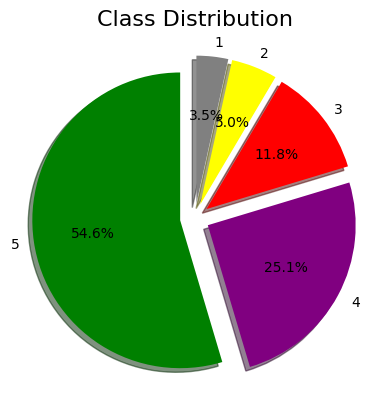

In [ ]:
###Rating Distribution###

# Distribution of the 5 different classes
class_distribution = data["Rating"].value_counts()

# Graph generation
fig, ax = plt.subplots()
ax.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90,
       explode=[0.1, 0.1 , 0.1 , 0.1, 0.1], shadow=True, textprops={'fontsize': 10}, colors=['green','purple', 'red', 'yellow', 'grey'])

# Aggiungi un titolo al grafico
ax.set_title("Class Distribution", fontsize=16)

# Mostra il grafico
plt.show()

It can be observed that the class of targets is unbalanced. In particular I choose not to deal with this data because since the dataset consists of so much data I expect it to be raprrepresentative of reality and therefore I want this division to remain in my design as well.

In [ ]:
###Identification of  Categorical Data###
categories=['object']
categorical_data=[]
df_cat=data.select_dtypes(include=categories)
for x in df_cat.head(1):
    print(f"{x}"+" is a categorical value")
    categorical_data.append(x)
print(f'the categorical value are: ', len(categorical_data),)

Year_Month is a categorical value
Reviewer_Location is a categorical value
Review_Text is a categorical value
Branch is a categorical value
the categorical value are:  4


Now i will analize better this column since they need to be preprocessed.

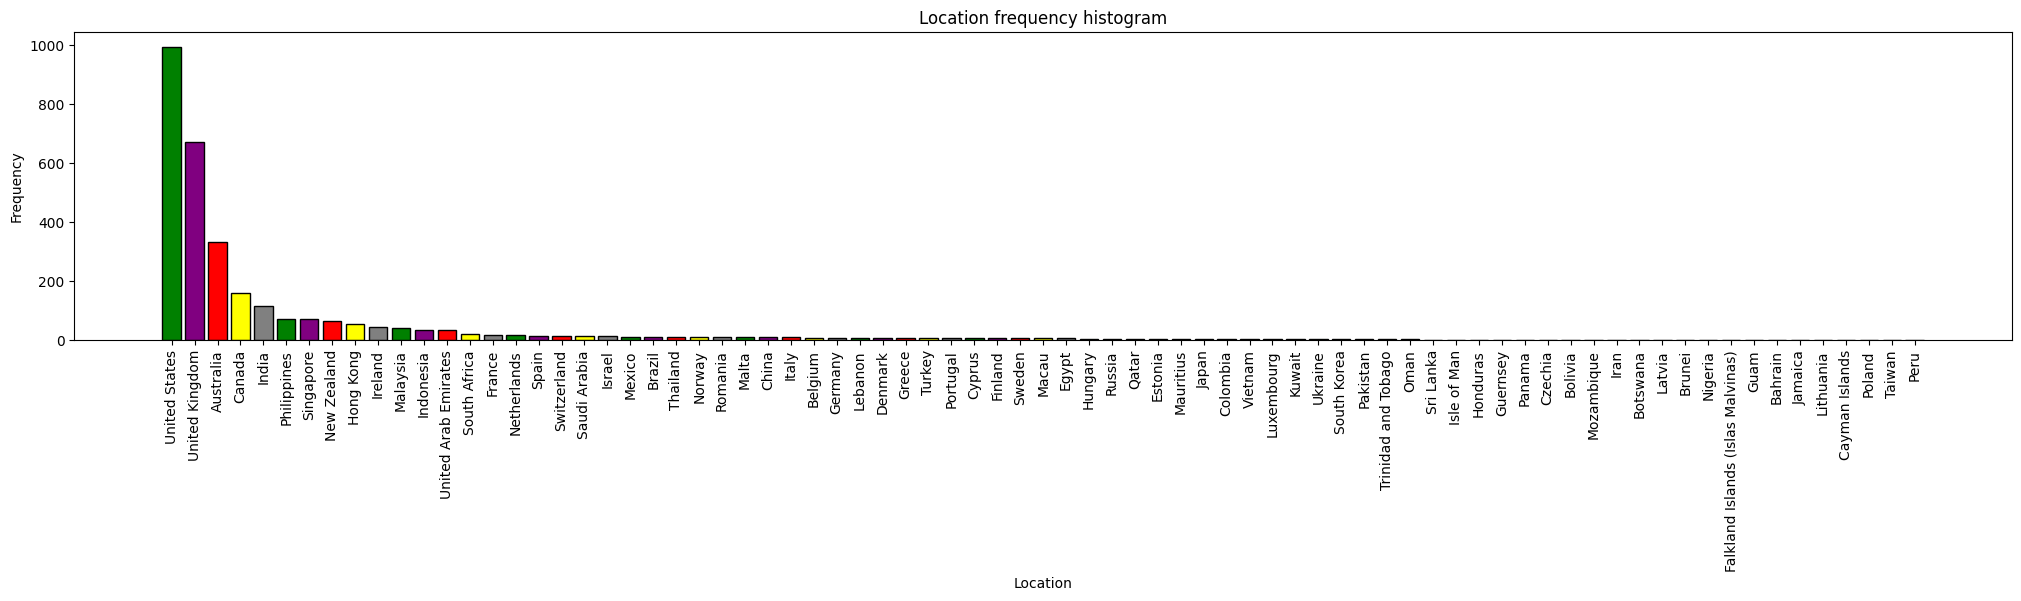

In [ ]:
### Reviwer location distribution ###
histogram = data['Reviewer_Location'].value_counts()

# Size of the feature
plt.figure(figsize=(25, 4))

# Plot the histogram
plt.bar(histogram.index, histogram.values ,  color=['green','purple', 'red', 'yellow', 'grey'], edgecolor='black')

# Add tags
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Location frequency histogram')

# rotation of the tex of 90 degrees
plt.xticks(rotation=90)

# show the final graph
plt.show()

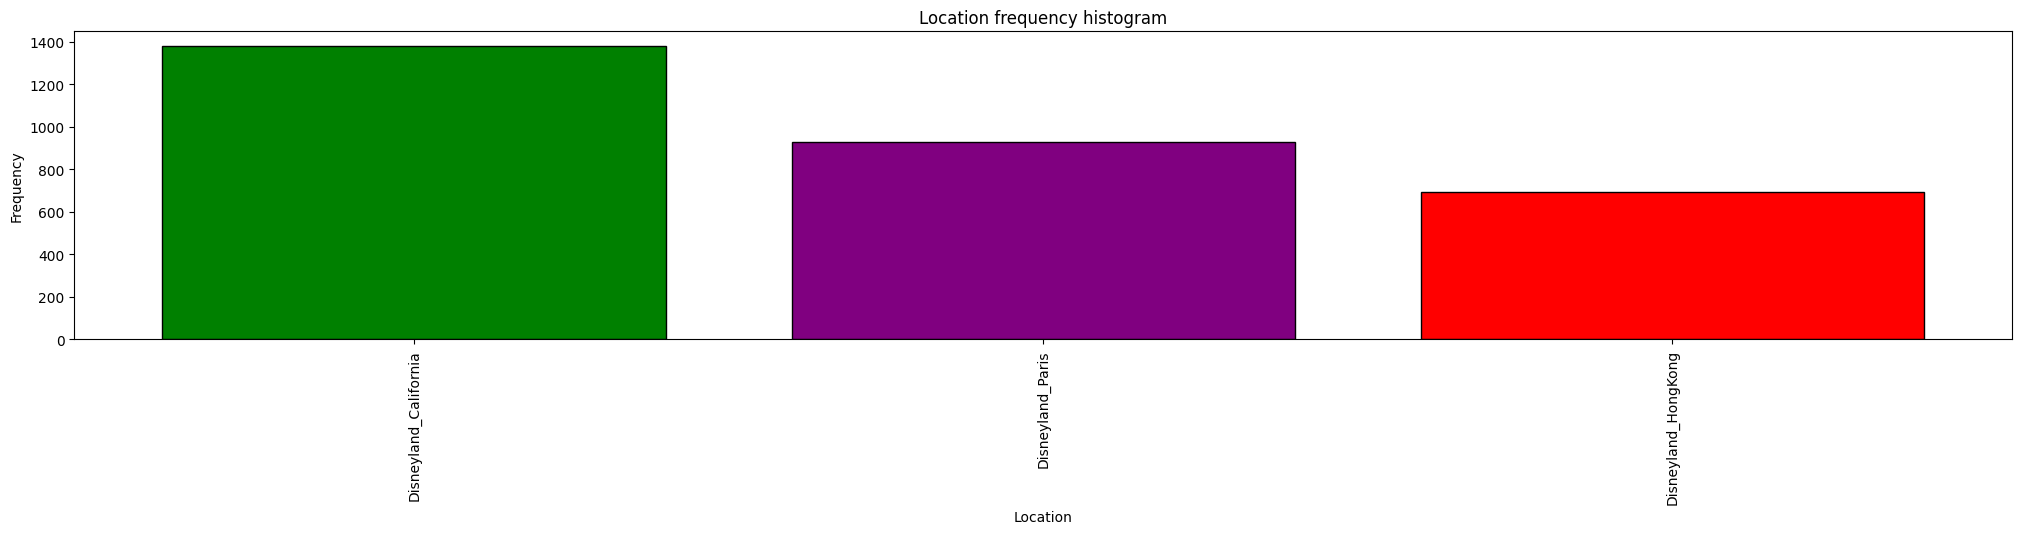

In [ ]:
### branch distribution ###
histogram = data['Branch'].value_counts()

# Size of the feature
plt.figure(figsize=(25, 4))

# Plot the histogram
plt.bar(histogram.index, histogram.values ,  color=['green','purple', 'red'], edgecolor='black')

# Add tags
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Location frequency histogram')

# rotation of the tex of 90 degrees
plt.xticks(rotation=90)

# show the final graph
plt.show()

\

From the EDA  I find that my input contains contain 42656  review,  in particular each review contain:
-  *Review_ID* : an unique and distinct ID,  I will not use it since the information contained there is just a tag to identify the rewiev but it not contains relevant information.

- *Rating:*  the rating which will be a target of my supervised learning task so  I will not use as an input but as  expected output.  

- *Year_Month:* a string containing the year and the month of the review. I will use it  as input after preprocessing.

- *Reviewer_Location*: a string containing the  country of origin of visitor. I will use after ever processing.  

- *Review_Text* which I will use after processing (embedding) as the input of an undercomplete autoencoder.

- *Branch* : string indicate which branch of the park, i will use it as input after preprocessing.

\

> ### **1.2: Preprocessing of the network input**



In the explonatory data analysis, I showed through an exploratory analysis the data in the table, dividing them into categorical and numerical showing their possible flaws and problems. In this second section, namely the preprocessing of my data I will prepare the dateset to be used as input of my MLP.

**Year_Month**

To process this information I have decided to divide it into two distinct information :
1. The first one contain the year as an integer and.
2. The second one contain a number from 1 to 4 , in particular I will map the month into a number which indicate the season,  this distinction is made it to add as a possible new input the season.



In [ ]:
##Mapping from month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 1  # winter
    elif month in [3, 4, 5]:
        return 2  # spring
    elif month in [6, 7, 8]:
        return 4  # summer
    else:
        return 3  # autumun

In [ ]:
# Create the new columns
data[['Year', 'Month']] = data['Year_Month'].str.split('-', expand=True)
data['Year'] = data['Year'].str.replace(' ', '')  # Remove the white space  in the new 'Year' column
data['Month'] = data['Month'].str.replace(' ', '')  #Remove the white space  in the new 'Month' columbs
data['Year'] = pd.to_numeric(data['Year'], errors='coerce') #Let value in the column numerical one
data['Month'] = pd.to_numeric(data['Month'], errors='coerce') #Let value in the column numerical one
data['Season'] = data['Month'].apply(get_season)

# Check for null values in 'Year' and 'Month' columns
null_values_year = data['Year'].isnull().sum()
null_values_month = data['Month'].isnull().sum()
print("Null values in 'Year':", null_values_year)
print("Null values in 'Month':", null_values_month)


Null values in 'Year': 209
Null values in 'Month': 209


I observe that at this point due to formatting errors in the dataset some values of [months] and [season] are not found. Since there are many data points and few null ones I can delete them

In [ ]:
# Cancel
data = data.dropna()

# Check for null values in 'Year' and 'Month' columns
null_values_year = data['Year'].isnull().sum()
null_values_month = data['Month'].isnull().sum()
print("Null values in 'Year':", null_values_year)
print("Null values in 'Month':", null_values_month)


Null values in 'Year': 0
Null values in 'Month': 0




\



**Reviewer_Location**


To the *Reviewer_Location* feature is possible to apply two different preprocessing operations, the first one is to apply a one-hot encoding obtaining a value 1 for the location of the reviewer feature and 0 in all the others, the second one is to obtain a tuple containg the possible values of geographical coordinate of the location. I choose the second type of preprocessing to have a less sparse matrix.

In [ ]:
df = data

# Prendi solo i valori unici dalla colonna 'Reviewer_Location'
unique_locations = df['Reviewer_Location'].unique()

# Crea un geocodificatore utilizzando il provider Nominatim
geolocator = Nominatim(user_agent='my_geocoder' , timeout= 100)

# Dizionario per memorizzare le coordinate dei valori unici
location_coordinates = {}

# Funzione per ottenere le coordinate geografiche a partire dal nome del paese
def get_coordinates(country):
    if country in location_coordinates:
        return location_coordinates[country]
    else:
        location = geolocator.geocode(country)
        if location is not None:
            coordinates = (location.latitude, location.longitude)
            location_coordinates[country] = coordinates
            return coordinates
        else:
            return None

# Aggiorna le coordinate nel DataFrame originale
tqdm.pandas()  # Inizializza la barra di avanzamento
df['Coordinates'] = df['Reviewer_Location'].progress_apply(get_coordinates)


100%|██████████| 2791/2791 [00:38<00:00, 72.69it/s] 


\

**Branch**



Branch is now preprocesed with the one hot encoding tecqnique describe as the first possibily of my solution in the previous section. So for each one of the branch i have a column where the possibile value are 1 = park is in this branch and 0= branch is not in this branch.

In [ ]:
# Apply one-hot encoding to the 'branch' column
data_encoded = pd.get_dummies(data['Branch'], prefix='Branch')

# Concatenate the encoded columns with the original DataFrame
data= pd.concat([data, data_encoded], axis=1)

#Drop Branch Column
data = data.drop('Branch', axis=1)
data= data.drop('Reviewer_Location',  axis=1)
data= data.drop('Review_ID',  axis=1)

data.head()

,Rating,Year_Month,Review_Text,Year,Month,Season,Coordinates,Branch_Disneyland_California,Branch_Disneyland_HongKong,Branch_Disneyland_Paris
0,5,2017-9,Disneyland is so beautiful and large.To see al...,2017.0,9.0,3,"(35.8885993, 14.4476911)",0,0,1
1,1,2011-10,"The lines for rides are too long. Yes, the fas...",2011.0,10.0,3,"(61.0666922, -107.991707)",1,0,0
2,5,2018-4,Loved Hong Kong Disneyland although it is much...,2018.0,4.0,2,"(-24.7761086, 134.755)",0,1,0
3,5,2015-9,Love Disneyland! We are annual pass holders an...,2015.0,9.0,3,"(39.7837304, -100.445882)",1,0,0
4,4,2013-11,The California Adventure Park is much improved...,2013.0,11.0,3,"(39.7837304, -100.445882)",1,0,0


\

**Review_Text**

Last feature , and also the most complex one to treat is the Review text. This since is a text require a particular encodind techniques called embedding. The branch of the Computer science that treat the embedding is called Natural language processing. In particular nowadays there are a lot of complex solution to treat text based on Deep neural networks, in particular there are two big ways to apply embedding:

1. Create a dense vector rapresentation use more recent techniques such as Word2Vec, GloVe, Bert or the  Transformers. I choose to not apply this type of embedding techniques for what i say in the first part. In fact to mantain the trade off between the accuracy and the complexity is more convenient to use another type of strategy. In fact model such as BERT	(that is a bidirectional recurrent neural netowrk) has the ability to capture the meaning in an efficient and consolidate way, altought its complexity is high. Another possible motivation was that since the exam was a deep learning exam, I preferred to focus more on the construction of the network used for classification than on the strategy of word emebedding since it was not one of the fundamental points covered in the course.

2. The second solution that is the one that i choose perhaps less precise and meaningful requires less complexity and is based on two points to be followed in the following order:
  - Creation of a tensor containing the embedding of words , which will be sparse.
  - Presence of an autoencoder, a particular neural network whose purpose is to predict its own input. In particular, the structure consists of two components (also two neural networks) called encoder and decoder . In particular I will use an undercomplete autoencoder where the encoder will have the goal of creating a more compact representation of the input.


`Text Embedding: `

In [ ]:
##Create the vector containing all the possible word in a ranked order
def create_word_vector(reviews):
    word_list = []
    for review in reviews:
        review = review.lower()
        words = re.findall(r'\b\w+\b', review)
        word_list.extend(words)

    word_counter = Counter(word_list)
    word_vector = sorted(word_counter.keys(), key=lambda x: word_counter[x], reverse=True)

    num = [word_counter[word] for word in word_vector]

    return word_vector, num

word_vector, num = create_word_vector(data['Review_Text'])
print(word_vector)
print(num)
len(num)

['the', 'and', 'to', 'a', 'of', 'we', 'it', 'in', 'was', 'for', 'i', 'is', 'you', 'park', 'but', 'were', 'that', 'at', 'on', 'are', 'as', 'with', 'disney', 'rides', 'there', 'so', 'have', 'not', 'disneyland', 't', 'all', 'this', 'time', 'day', 'my', 'be', 's', 'had', 'they', 'get', 'if', 'our', 'can', 'very', 'go', 'one', 'ride', 'great', 'just', 'from', 'would', 'which', 'more', 'your', 'food', 'kids', 'or', 'do', 'place', 'some', 'good', 'really', 'when', 'an', 'only', 'see', 'like', 'up', 'will', 'visit', 'out', 'about', 'went', 'been', 'no', 'much', 'also', 'than', 'back', 'us', 'people', 'fast', 'long', 'by', 'fun', 'parks', 'parade', '2', 'experience', 'pass', 'even', 'wait', 'many', 'well', 'what', 'other', 'around', 'days', 'first', 'too', 'most', 'did', 'times', 'children', 'world', 'still', 'don', 'show', 'year', 'then', 'here', 'characters', 'them', 'take', 'before', 'got', 'mountain', 'over', 'staff', 'could', 'fireworks', 'expensive', 'lines', 'family', 'small', '3', 'line

11296

In [ ]:
###Correction of spelling errors of unique words
def spell_check(word_list):
    spell = SpellChecker()
    corrected_list = []

    for i, word in enumerate(word_list):
        corrected_word = spell.correction(word)
        corrected_list.append(corrected_word)


    return corrected_list

corrected_list = spell_check(word_vector)
print(corrected_list)


['the', 'and', 'to', 'a', 'of', 'we', 'it', 'in', 'was', 'for', 'i', 'is', 'you', 'park', 'but', 'were', 'that', 'at', 'on', 'are', 'as', 'with', 'disney', 'rides', 'there', 'so', 'have', 'not', 'disneyland', 'i', 'all', 'this', 'time', 'day', 'my', 'be', 'i', 'had', 'they', 'get', 'if', 'our', 'can', 'very', 'go', 'one', 'ride', 'great', 'just', 'from', 'would', 'which', 'more', 'your', 'food', 'kids', 'or', 'do', 'place', 'some', 'good', 'really', 'when', 'an', 'only', 'see', 'like', 'up', 'will', 'visit', 'out', 'about', 'went', 'been', 'no', 'much', 'also', 'than', 'back', 'us', 'people', 'fast', 'long', 'by', 'fun', 'parks', 'parade', '2', 'experience', 'pass', 'even', 'wait', 'many', 'well', 'what', 'other', 'around', 'days', 'first', 'too', 'most', 'did', 'times', 'children', 'world', 'still', 'don', 'show', 'year', 'then', 'here', 'characters', 'them', 'take', 'before', 'got', 'mountain', 'over', 'staff', 'could', 'fireworks', 'expensive', 'lines', 'family', 'small', '3', 'line

In [ ]:
#Create the final vector of all possible unique words
valori_unici = []
for valore in corrected_list:
    if valore not in valori_unici:
        valori_unici.append(valore)
print(valori_unici) #List of all possible word in a ranked order
print(len(valori_unici)) #Number of unique word that i considered

['the', 'and', 'to', 'a', 'of', 'we', 'it', 'in', 'was', 'for', 'i', 'is', 'you', 'park', 'but', 'were', 'that', 'at', 'on', 'are', 'as', 'with', 'disney', 'rides', 'there', 'so', 'have', 'not', 'disneyland', 'all', 'this', 'time', 'day', 'my', 'be', 'had', 'they', 'get', 'if', 'our', 'can', 'very', 'go', 'one', 'ride', 'great', 'just', 'from', 'would', 'which', 'more', 'your', 'food', 'kids', 'or', 'do', 'place', 'some', 'good', 'really', 'when', 'an', 'only', 'see', 'like', 'up', 'will', 'visit', 'out', 'about', 'went', 'been', 'no', 'much', 'also', 'than', 'back', 'us', 'people', 'fast', 'long', 'by', 'fun', 'parks', 'parade', '2', 'experience', 'pass', 'even', 'wait', 'many', 'well', 'what', 'other', 'around', 'days', 'first', 'too', 'most', 'did', 'times', 'children', 'world', 'still', 'don', 'show', 'year', 'then', 'here', 'characters', 'them', 'take', 'before', 'got', 'mountain', 'over', 'staff', 'could', 'fireworks', 'expensive', 'lines', 'family', 'small', '3', 'line', 'their'

In [ ]:
##Function able to create a vector of the embedding vector
def create_vector(text, word_list):
    output_vector = [0] * len(word_list)  # Inizializza il vettore di output con valori 0
    words = text.split()  # Divide il testo in parole

    for word in words:
        lowercase_word = word.lower()  # Converte la parola in minuscolo
        if lowercase_word in word_list:
            index = word_list.index(lowercase_word)  # Ottieni l'indice della parola nel vettore di parole
            output_vector[index] += 1  # Incrementa il valore corrispondente nel vettore di output

    return output_vector


In [ ]:
embedding = []
data.reset_index(drop=True, inplace=True)
for i in tqdm(range(len(data.index))):
    output_vector = create_vector(data['Review_Text'][i], corrected_list)
    embedding.append(output_vector)

100%|██████████| 2791/2791 [00:16<00:00, 166.08it/s]


` Undercomplete Autoencoder`

From the embedded rapresentation of my input i will create an undercomplete underencoder to learn a less dimensional rapresentation. In particular i will expected for the zips law that the fundamental value are in the center of my vector. To do it i will use an autoencoder formed in the following way.

In [ ]:
matrix = np.array(embedding) #From vector of vector into matrix

In [ ]:
# Convert data in float32
matrix = matrix.astype('float32')

In [ ]:
#Divide data into train and test
train_data, test_data = train_test_split(matrix, test_size=0.2) #Split into test and training Data

In [ ]:
# Create the autoencoder
input_dim = train_data.shape[1] # Dimensionality of the input data
encoding_dim = 20  # Desired encoding dimensionality

# Encoder
encoder = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    keras.layers.Dense(encoding_dim, activation='relu')
])

# Decoder
decoder = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(encoding_dim,)),
    keras.layers.Dense(input_dim, activation='sigmoid')
])

# Complete Autoencoder
autoencoder = keras.models.Sequential([encoder, decoder])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(train_data, train_data, epochs=10, batch_size=32, validation_data=(test_data, test_data))


Epoch 1/10
70/70 [==============================] - 6s 9ms/step - loss: 0.1001 - val_loss: 0.0356
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0344 - val_loss: 0.0353
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: 0.0352
Epoch 4/10
70/70 [==============================] - 0s 6ms/step - loss: 0.0342 - val_loss: 0.0352
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: 0.0352
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.0351
Epoch 7/10
70/70 [==============================] - 0s 6ms/step - loss: 0.0340 - val_loss: 0.0349
Epoch 8/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0338 - val_loss: 0.0348
Epoch 9/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0338 - val_loss: 0.0348
Epoch 10/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0337 - val_loss: 0.0347


In [ ]:
# obtain encoder output (Embedding)
encoder_output = encoder.predict(matrix)
print(encoder_output)


88/88 [==============================] - 0s 2ms/step
[[ 4.8200903  6.1029096  0.        ...  0.         4.136993   5.889848 ]
 [10.770123  15.9935255  0.        ...  0.         8.330865  10.30029  ]
 [ 3.5697827  3.9252484  0.        ...  0.         3.6965635  5.2822742]
 ...
 [ 5.7955556  8.619523   0.        ...  0.         4.705329   6.1121845]
 [19.305162  28.989498   0.        ...  0.        13.832859  17.24439  ]
 [ 4.616078   6.3969145  0.        ...  0.         4.2757206  5.673564 ]]


> ### **1.3: Input of the network**



So my tabular input after preprocessing will be this:

In [ ]:
# Function to convert an array row to an embedding cell
def convert_row_to_embedding(row):
    return row.tolist()

#Create the 'embedding' column
data['embedding'] = encoder_output.tolist()

# visualize the final dataset
data = data.drop('Review_Text', axis=1)
y=data['Rating']
data = data.drop('Rating', axis=1)
data.head()

,Year_Month,Year,Month,Season,Coordinates,Branch_Disneyland_California,Branch_Disneyland_HongKong,Branch_Disneyland_Paris,embedding
0,2017-9,2017.0,9.0,3,"(35.8885993, 14.4476911)",0,0,1,"[4.820090293884277, 6.102909564971924, 0.0, 0...."
1,2011-10,2011.0,10.0,3,"(61.0666922, -107.991707)",1,0,0,"[10.770122528076172, 15.993525505065918, 0.0, ..."
2,2018-4,2018.0,4.0,2,"(-24.7761086, 134.755)",0,1,0,"[3.5697827339172363, 3.925248384475708, 0.0, 0..."
3,2015-9,2015.0,9.0,3,"(39.7837304, -100.445882)",1,0,0,"[3.489677906036377, 3.874861717224121, 0.0, 0...."
4,2013-11,2013.0,11.0,3,"(39.7837304, -100.445882)",1,0,0,"[11.393685340881348, 15.745537757873535, 0.0, ..."


Getting to this point this will be the input for my MLP , specifically so that my MLP can receive this table as input:
- Divide the coordinate tuple into two coordinates called latitude and longitude.
- Divide my embedding into several columns based on the length of the embedding vector.

In [ ]:
# Convert the  Coordinate column into two numerics columns
data[['Latitude', 'Longitude']] = data['Coordinates'].apply(lambda x: pd.Series(str(x).strip('()').split(','))).astype(float)

####Converti the embedding in single columns####

embedding_array = np.array(data['embedding'].tolist())
# Creating a DataFrame for embedding.
embedding_df = pd.DataFrame(embedding_array, columns=[f'embedding_{i}' for i in range(embedding_array.shape[1])])
#Chain the DataFrame of the embedding with the original dataset.
data = pd.concat([data, embedding_df], axis=1)

columns_to_convert = ['Branch_Disneyland_HongKong', 'Branch_Disneyland_Paris', 'Branch_Disneyland_California' ]  # Replace with the actual column names
data[columns_to_convert] = data[columns_to_convert].astype(float)


In [ ]:
# Remove columns
data = data.drop('Coordinates', axis=1)
data = data.drop('embedding', axis=1)
data = data.drop('Year_Month', axis=1)

In [ ]:
#Input of the MLP
data.head()

,Year,Month,Season,Branch_Disneyland_California,Branch_Disneyland_HongKong,Branch_Disneyland_Paris,Latitude,Longitude,embedding_0,embedding_1,...,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19
0,2017.0,9.0,3,0.0,0.0,1.0,35.888599,14.447691,4.820090,6.102910,...,5.204967,5.538179,3.076127,0.0,0.0,0.0,0.0,0.0,4.136993,5.889848
1,2011.0,10.0,3,1.0,0.0,0.0,61.066692,-107.991707,10.770123,15.993526,...,11.105285,12.046304,7.435307,0.0,0.0,0.0,0.0,0.0,8.330865,10.300290
2,2018.0,4.0,2,0.0,1.0,0.0,-24.776109,134.755000,3.569783,3.925248,...,4.108767,4.273774,1.966912,0.0,0.0,0.0,0.0,0.0,3.696563,5.282274
3,2015.0,9.0,3,1.0,0.0,0.0,39.783730,-100.445882,3.489678,3.874862,...,4.122281,4.241457,2.011816,0.0,0.0,0.0,0.0,0.0,3.845746,5.317214
4,2013.0,11.0,3,1.0,0.0,0.0,39.783730,-100.445882,11.393685,15.745538,...,12.249956,12.981879,7.592472,0.0,0.0,0.0,0.0,0.0,9.736085,12.417109


## *2)The output layer*



In this and the following section 3 and 4 i will construct my network give motivation about my choices. In particular  i start from the output layer. As an outp
ut layer i used a fully connected layer of n-classes , where the number of n correspond to the possible classes, so 5, one for each target (Note: I write 6 in the exam because i was wondering that 0 was one of the possible rating, but the idea remain the same, one neuron for each possible classes with a softmax activation function). In particular each of this neuron contains as an activation the softmax, a generalizaiton of the sigmoid which give me as an output a probability to be in one of each classes, one for each neuron. In particular the distribution of this probability if summed are one.

In particular the softmax activation function has the following formula:




  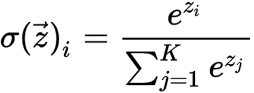




\

## *3)  Activation and loss function*



> ### **3.1: Activation function**



In some of the following section i will put more than one possible solution ( 3 activation function  , 2 regularizers, ...). This beacuse all this value will be tested and then choosed in base of the optimal combination in the section 5.

As possible activation function of my network i porposed:

- **Sigmoid activation function**: a S-shaped monotonic activation function used in a lot of deep learning models. It's also used in the ML logistic regression model. The sigmoid function was introduced in a series of three papers by Pierre Francios Verhulst between 1838 and 1847, who devised it as a model of population growth by adjusting the exponential growth model.

    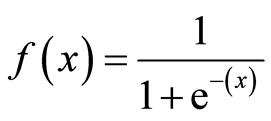




- **ReLU (Rectified linear unit)  :** The ReLU is one the most used activation function in the world right now. Since, it is used in almost all the convolutional neural networks.The ReLU is half rectified (from bottom). f(z) is zero when z is less than zero and f(z) is equal to z when z is above or equal to zero. Similar to linear units, but outputs zero across half its domain.

  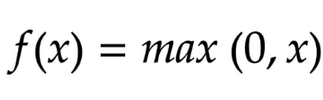

- **Swish activation function**: Proposed by Google Brain in 2017. Swish is a gated version of the sigmoid activation function. Swish is a smooth, non-monotonic function. unlike ReLU. The non-monotonicity property of Swish distinguishes itself from most common activation functions. Non-monotonicity of Swish increases expressivity and improves gradient flow.Swish performs better than ReLU on deeper models across many challenging datasets. Like ReLU, Swish is unbounded above and bounded below. Unbounded above is desirable in the activation function to avoid saturation, and bounded below helps with a strong regularization effect. The simplicity of Swish and its similarity to ReLU gives better performance for deep neural networks by just replacing ReLU with Swish, which is just a simple one-line code change.

  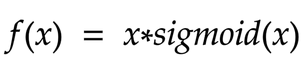



Graphycally we have:

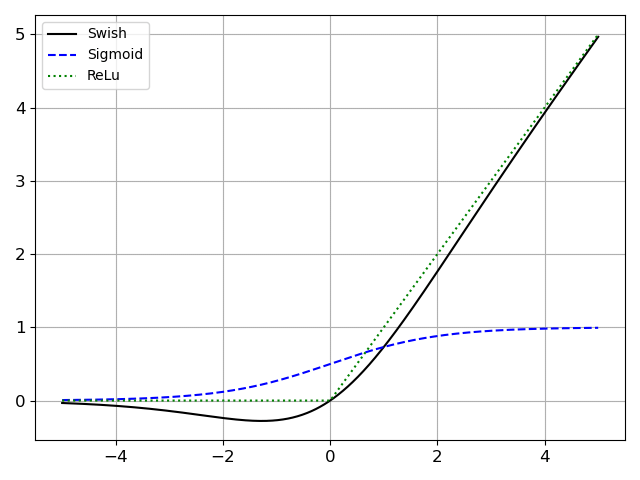

> ### **3.2: Loss function**

As a loss function I use the Sparse categorical cross-entropy , a keras implemantation of the cross entropy , a measure of how much a distribution P(x) is determined gived a distribution Q(x) on the same input random variable. This extension of the categorical cross-entropy loss function that is used when the output labels are represented in a sparse matrix format. In a sparse matrix format, the labels are represented as a single index value rather than a one-hot encoded vector. In particular to use it we map the labels from {1,2,3,4,5} into {0,1,2,3,4}.

  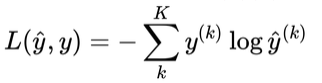

In [ ]:
#Change the possible labels value to use the sparse categorical cross entropy
y=y-1

## *4) Regularizers,Initializers, Normalizers, Dropout, Optimizers, Learning rate, Batch size, Number of layers , Numbers of neurons for each layers*

> ### **4.1: Weight and bias regularizers**


Regularization is a set of techniques that can prevent overfitting in neural networks and thus improve the accuracy of a Deep Learning model when facing completely new data from the problem domain. In particular i will use two different types of regularizers:

- **L2 regularization.**
   
  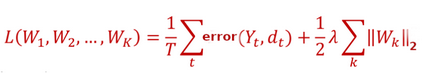

- **L1 regularization.**

  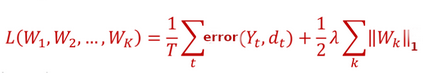


> ### **4.2: Weight and bias initializers**

The weight initialization is the method that our deep learning algorithm use to initialize the value of the weight. So set the value of the weight at epoch 0.
Kernel/weights initialization : Appropriately initializing weights in a layer can help convergence and mitigate vanishing/exploding gradient problems. In particular i will try the following initializers:
- **Glorot/Xavier uniform.**
- **He uniform.**



> ### **4.3: Batch Normalization**



Batch normalization is a technique used in deep learning models to normalize the activations of intermediate layers during training. It was introduced to address the challenges of internal covariate shift and to improve the stability and convergence of neural networks.

> ### **4.4: Dropout**


Droput is another technique to prevent overfitting. Dropout is a regularization technique for neural network models proposed by Srivastava et al. in their 2014 paper “Dropout: A Simple Way to Prevent Neural Networks from Overfitting”.
Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass. In particular i will try different dropout values


> ### **4.5: Optimizers**

Theoretically the optimizers are based on the Gradient descented , a recursively technique  used to find the optimal weight to minimize the error. In my project i will use two variants wich contains also the momentum and the decaying learning rate. Momentum and decaying learning rate are techniques commonly used in combination with optimization algorithms to enhance the training process and improve the performance of deep learning models. In particular as optimizers i use:
- **Stochastic Gradient Descent (SGD)**
- **Adam (Adaptive Moment Estimation)**

> ### **4.6: Learning Rate**



The learning rate is a hyperparameter that determines the step size at which the optimization algorithm updates the model's parameters during training. It controls how quickly or slowly the model learns from the gradients computed on the training data. For this reason i will try more values for the learning rate.

> ### **4.7: Batch Size**



As a batch size i use a tecnique called **mini-batch** a training technique used in deep learning where the training data is divided into small subsets or batches for more efficient and effective model optimization. Instead of using the entire dataset in each iteration, minibatch training processes a subset of data at a time

> ### **4.8: Number Of layers**

I will try different size for my network. In particular choosing the size of my network could be done in two ways: the first one is use a ciclyc structure to test different depth. The second one consist to choose by hand different lenght to reach a good compromise between accuracy and complexity. I choose to use the second way.

> ### **4.9: Number of Neuron for each layer**


I will try different size for my layers. In particular choosing the size of inner layer could be fundamenal to have a network with a good ability to solve the problems. I will try different values and combination.

> ### **4.10:  Example of  a possible Solution**

In [ ]:

# Test and train set division
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create my MLP
model = Sequential()

# Options
activation = 'ReLU'  # Activation function for all layers
loss_function = 'sparse_categorical_crossentropy'
optimizer = 'adam'
num_neurons = [100, 50, 10, 5]
num_layers = len(num_neurons)
epochs = 10
batch_size = 100

# Add the input layer
model.add(Dense(num_neurons[0], activation=activation, input_shape=(X_train.shape[1],)))

# Add the hidden layers
for i in range(1, num_layers):
    model.add(Dense(num_neurons[i], activation=activation))

# Add the output layer
model.add(Dense(num_neurons[-1], activation='softmax'))

# Compie the model
model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

# training
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))


# Valuation  of the model on the test set
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Predict
y_pred = model.predict(X_test)

Epoch 1/10
23/23 [==============================] - 2s 12ms/step - loss: 1.5482 - accuracy: 0.2222 - val_loss: 1.4772 - val_accuracy: 0.2594
Epoch 2/10
23/23 [==============================] - 0s 5ms/step - loss: 1.4072 - accuracy: 0.2625 - val_loss: 1.3296 - val_accuracy: 0.3792
Epoch 3/10
23/23 [==============================] - 0s 8ms/step - loss: 1.2333 - accuracy: 0.5363 - val_loss: 1.1964 - val_accuracy: 0.5295
Epoch 4/10
23/23 [==============================] - 0s 7ms/step - loss: 1.1498 - accuracy: 0.5596 - val_loss: 1.1871 - val_accuracy: 0.5295
Epoch 5/10
23/23 [==============================] - 0s 9ms/step - loss: 1.1358 - accuracy: 0.5591 - val_loss: 1.1874 - val_accuracy: 0.5295
Epoch 6/10
23/23 [==============================] - 0s 8ms/step - loss: 1.1308 - accuracy: 0.5591 - val_loss: 1.1859 - val_accuracy: 0.5259
Epoch 7/10
23/23 [==============================] - 0s 7ms/step - loss: 1.1238 - accuracy: 0.5591 - val_loss: 1.1856 - val_accuracy: 0.5259
Epoch 8/10
23/23 [=

## *5)Hyperparameter selection*

To make the hyperparameter selection, it is critical to note that there are two main techniques in my project:
1. First will be used only for the `number of layers` and consists of finding by hand  various depth to find the a sub-oprimal one.

2. The second technique, on the other hand, that I will use with` all the others` is called gridsearch.





> ### **5.1: Number of layers selection**

As mentioned in the introduction to select the number of layers I decide to make a hand selection. In particular I decide to have at least two layers since as Baldi and Hornick demonstrated in 1989 one layer leads only to saddle points. I also try to use few layers to avoid the problems of exploding and vanishing gradient.

> ### **5.2: Model tuning with grid search**

Grid search is a technique used in machine learning to find the optimal hyperparameters for a given model. It involves exhaustively searching through a predefined set of hyperparameter values to determine the combination that yields the best performance.

The grid search algorithm works by defining a grid of hyperparameter values to explore. Each combination of hyperparameters in the grid is then used to train and evaluate the model using cross-validation. Cross-validation is a technique that involves splitting the data into multiple subsets or folds and training the model on some of the folds while evaluating its performance on the remaining fold. This helps to mitigate the risk of overfitting and provides a more reliable estimate of the model's performance.

After evaluating all combinations of hyperparameters, the grid search algorithm selects the combination that achieved the best performance according to the chosen metric. This combination of hyperparameters is then used to train the final model on the entire dataset, and it can be used to make predictions on new, unseen data.

To apply the grid search on my MLP i could use Scikeras, a library that integrates scikit-learn and Keras, providing a scikit-learn compatible API for building and tuning Keras models.

In [ ]:
### Define The structure to use in the grid search ###

def create_model(nhid1, nhid2, nhid3, # nhidi: number of hidden neurons in the i  layer
                 learning_rate= 10**-1, # learning_rate: the learning rate to be used by the optimizer
                 loss='sparse_categorical_crossentropy',   # loss: loss function to be used
                 hid_act='sigmoid',   # hid_act: activation function for hidden layers
                 out_act='softmax', # out_act: activation function for output layer
                 dropout_rate=0,    # dropout_rate: the rate of dropout to be used
                 optimizer="adam",
                 weight_reg=None, #Weight regularizers
                 weight_ini=None,
                 batch_size=batch_size): #Weight initializers

  model = Sequential()
  # Add the input layer
  model.add(Dense(nhid1, activation=hid_act, input_shape=(X_train.shape[1], ),kernel_initializer=weight_ini, kernel_regularizer=weight_reg))
  model.add(Dropout(dropout_rate))

  #Add batch Normalization
  model.add(keras.layers.BatchNormalization())

  #Add 1st hidden layer
  model.add(Dense(nhid2, activation=hid_act, kernel_initializer=weight_ini, kernel_regularizer=weight_reg))
  model.add(Dropout(dropout_rate))

  #Add batch Normalization
  model.add(keras.layers.BatchNormalization())

  #Add 2ND hidden layer
  model.add(Dense(nhid3, activation=hid_act, kernel_initializer=weight_ini, kernel_regularizer=weight_reg ))
  model.add(Dropout(dropout_rate))


  #Output Layer
  model.add(Dense(5, activation=out_act, kernel_initializer=weight_ini, kernel_regularizer=weight_reg))


  model.compile(loss=loss, optimizer=optimizer ,metrics=['accuracy'])
  return model


In [ ]:
# Wrapper class for scikit-learn API
model = KerasClassifier(model=create_model,
                        nhid1 = 100,
                        nhid2=50,
                        nhid3=25,
                        epochs=10,
                        batch_size=30)

In [ ]:
#learning the model on all data (iS THE SKLEARN one)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
23/23 [==============================] - 3s 15ms/step - loss: 1.8057 - accuracy: 0.0999 - val_loss: 1.6753 - val_accuracy: 0.0268
Epoch 2/10
23/23 [==============================] - 0s 6ms/step - loss: 1.4800 - accuracy: 0.3396 - val_loss: 1.4795 - val_accuracy: 0.5009
Epoch 3/10
23/23 [==============================] - 0s 6ms/step - loss: 1.3156 - accuracy: 0.4969 - val_loss: 1.3734 - val_accuracy: 0.5295
Epoch 4/10
23/23 [==============================] - 0s 6ms/step - loss: 1.2312 - accuracy: 0.5538 - val_loss: 1.3175 - val_accuracy: 0.5295
Epoch 5/10
23/23 [==============================] - 0s 7ms/step - loss: 1.1902 - accuracy: 0.5560 - val_loss: 1.2837 - val_accuracy: 0.5295
Epoch 6/10
23/23 [==============================] - 0s 7ms/step - loss: 1.1630 - accuracy: 0.5632 - val_loss: 1.2626 - val_accuracy: 0.5295
Epoch 7/10
23/23 [==============================] - 0s 6ms/step - loss: 1.1468 - accuracy: 0.5636 - val_loss: 1.2485 - val_accuracy: 0.5295
Epoch 8/10
23/23 [=

KerasClassifier(
	model=<function create_model at 0x7ebea9f080d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=30
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	nhid1=100
	nhid2=50
	nhid3=25
	class_weight=None
)

In [ ]:
## define the grid search parameters for the number of neurons in the hidden layers
nhid1 = [100, 75]
nhid2 = [50]
nhid3 = [25]

## define the grid search parameters for the learning rate
lr = [10**-3, 10**-1]

## define the grid search parameters for the dropout rate
dp=[0, 0.1]

## define the grid search parameters for the initializers
wi = ['glorot_uniform', 'he_uniform']

## define the grid search parameters for the optimizers
opt = ['adam', 'sgd']

## define the grid search parameters for the activation function of hidden neurons
hid_act = ['relu', 'sigmoid', 'swish']

## define the grid search parameters for the weight regularizers
weight_regularizers = ['l1', 'l2']

## define the grid search parameters for the batch size
batchsize=[30,20]

## Create dictionary,  dictionary names must start with model__,if it is an argument of the model,  followed by the model argument name
param_grid = dict(model__nhid1= nhid1,
                  model__nhid2= nhid2,
                  model__nhid3= nhid3,
                  model__learning_rate= lr,
                  model__hid_act= hid_act,
                  model__dropout_rate=dp,
                  model__optimizer=opt,
                  model__batch_size=batchsize,
                  model__weight_ini=wi
                  )

# Grid search
GS = GridSearchCV(estimator=model, param_grid=param_grid,
                  n_jobs=-1,
                  scoring='accuracy',
                  cv=2,
                  verbose=3)

# Results of the grid search
grid_result = GS.fit(X_train, y_train)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/10
75/75 [==============================] - 2s 5ms/step - loss: 1.2737 - accuracy: 0.5305
Epoch 2/10
75/75 [==============================] - 0s 5ms/step - loss: 1.2176 - accuracy: 0.5524
Epoch 3/10
75/75 [==============================] - 0s 4ms/step - loss: 1.1968 - accuracy: 0.5547
Epoch 4/10
75/75 [==============================] - 0s 4ms/step - loss: 1.1819 - accuracy: 0.5578
Epoch 5/10
75/75 [==============================] - 0s 5ms/step - loss: 1.1845 - accuracy: 0.5470
Epoch 6/10
75/75 [==============================] - 0s 4ms/step - loss: 1.1802 - accuracy: 0.5542
Epoch 7/10
75/75 [==============================] - 0s 5ms/step - loss: 1.1796 - accuracy: 0.5569
Epoch 8/10
75/75 [==============================] - 0s 5ms/step - loss: 1.1743 - accuracy: 0.5529
Epoch 9/10
75/75 [==============================] - 0s 4ms/step - loss: 1.1715 - accuracy: 0.5565
Epoch 10/10
75/75 [==============================] - 0s 5ms/step - loss: 1.1712 - accuracy: 0.5497


In [ ]:
grid_result

GridSearchCV(cv=2,
             estimator=KerasClassifier(batch_size=30, epochs=10, model=<function create_model at 0x7ebea9f080d0>, nhid1=100, nhid2=50, nhid3=25),
             n_jobs=-1,
             param_grid={'model__batch_size': [30, 20],
                         'model__dropout_rate': [0, 0.1],
                         'model__hid_act': ['relu', 'sigmoid', 'swish'],
                         'model__learning_rate': [0.001, 0.1],
                         'model__nhid1': [100, 75], 'model__nhid2': [50],
                         'model__nhid3': [25],
                         'model__optimizer': ['adam', 'sgd'],
                         'model__weight_ini': ['glorot_uniform', 'he_uniform']},
             scoring='accuracy', verbose=3)

In [ ]:
# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))


Best: 0.562276 using {'model__batch_size': 20, 'model__dropout_rate': 0.1, 'model__hid_act': 'sigmoid', 'model__learning_rate': 0.001, 'model__nhid1': 100, 'model__nhid2': 50, 'model__nhid3': 25, 'model__optimizer': 'sgd', 'model__weight_ini': 'glorot_uniform'}


## *6)Generalization capability of my model*

> ### **6.1: Technique used to test generalization capability**


To ensure the generalization ability of my model, I adopt a two-step approach. Firstly, I split my input data into training and test sets. The training set (X_train and y_train) is used to train the model, while the test set remains untouched for evaluation. This separation allows me to assess how well the model performs on unseen data.

To further enhance the accuracy and generalization capability of my model, I employ a grid search with 3-fold cross-validation. This technique evaluates the model's performance on multiple subsets of the training data. By exploring different combinations of hyperparameters defined in a parameter grid, I can select the best set of parameters that yield optimal performance.

During the grid search, the model is trained and evaluated for each combination of hyperparameters. The dataset is divided into three subsets (folds), and the model is trained and evaluated three times. Each time, a different fold is used as the validation set, while the remaining folds are used for training. This cross-validation approach helps mitigate the risk of overfitting by providing a robust estimate of the model's generalization ability.

By selecting the hyperparameters that yield the best performance across the different folds, I aim to find a model configuration that can generalize well to unseen data. This strategy strikes a balance between overfitting and underfitting. Overfitting occurs when the model performs well on the training data but poorly on the test data, indicating it has learned specific patterns that do not generalize. Underfitting, on the other hand, happens when the model performs poorly on both the training and test data, indicating a lack of capturing the underlying patterns.

Once the grid search is complete and the best set of hyperparameters is determined, I apply the trained model to the test data. The test set, which the model has not encountered during training or hyperparameter selection, serves as an independent evaluation to assess the model's ability to generalize to unseen data. If the model performs well on the test set, it indicates that it has successfully learned meaningful patterns and can make accurate predictions on new, unseen examples.

In summary, the strategy I follow involves splitting the data into train and test sets, conducting a grid search with cross-validation on the train set to find the best hyperparameters, and finally evaluating the trained model on the separate test set. This approach aims to strike a balance between overfitting and underfitting, ensuring that the model achieves good performance on both the training and test data while demonstrating generalization to new, unseen data.

> ### **6.2:Model Evalutation**

For the model Evaluation i will use the Confusion Matrix, the learning curve and the validation curve.


**1) Confusion Matrix**

The confusion matrix, also known as an error matrix, is a fundamental tool for evaluating the performance of a multiclass classification model. It provides valuable insights into the model's predictions by showing the number of correct and incorrect predictions made for each output class. The confusion matrix is organized in a table format, where the rows represent the true classes and the columns represent the predicted classes. The elements within the matrix indicate the number of instances that have been correctly or incorrectly classified for each class pair. This information is extremely useful as it provides a detailed overview of the model's performance for each output class. From the confusion matrix, various evaluation metrics can be calculated, such as accuracy, precision, recall.
- Accuracy represents the percentage of correct predictions out of the total predictions.
- Precision measures the proportion of correctly predicted positive instances out of all positive predictions made for a specific class.
- Recall indicates the proportion of actual positive instances that have been correctly predicted out of the total positive instances for a class.

19/19 [==============================] - 0s 2ms/step


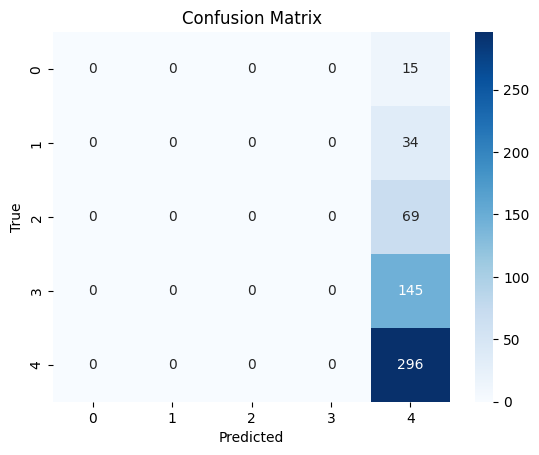

In [ ]:
# Use the best estimator found with the second hyperparameter tuning
cls = grid_result.best_estimator_

# Predict labels on the test set
y_pred = cls.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Generally a good confusion matrix should exhibit a dominant diagonal with higher values along the main diagonal. This indicates that the model made correct predictions for the majority of instances in each class. Additionally, it is desirable to have low values off the main diagonal, as they represent classification errors. Ideally, all cells off the main diagonal to have low values.

However, my confusion matrix has null values except in the bottom-right corner, it suggests a problem with my multiclass classification model. This indicates that my model is predominantly predicting only one class while ignoring the other classes.

This should be cause by imbalanced data, in fact in my input data the label 5 is the most present and as i explicate in the EDA "I choose not to deal with this data because since the dataset consists of so much data I expect it to be raprrepresentative of reality and therefore I want this division to remain in my design as well." So given that there are really 5 labels for most of my samples I can conclude that given how I treated the problem I can be averagely satisfied with what my confusion matrix indicates to me, noting however that it is not a perfect result due probably to a very simplified text embedding technique compared to the more complex and current ones based on the use of RNNs.


**2)Precision-Recall Curve Curve**

The learning curve provides insights into the model's behavior based on the size of the training set. It consists of two curves: the training accuracy and the validation accuracy.

A good learning curve shows a progressive increase in training accuracy as the size of the training set grows. This indicates that the model is learning from the training data and becoming better at correctly predicting labels.

The validation accuracy should initially increase with the growth of the training set size. This indicates that the model is able to generalize well from the training data to the test data. However, after a certain point, the validation accuracy may stabilize or even decrease, which can be caused by factors such as model complexity or noise in the data.

A convergence point between the training and validation curves indicates that the model has reached a balance between underfitting and overfitting. If the curves are very close or overlap, it suggests that the model is effectively learning from the training data and generalizing well to the test data.

The distance between the training and validation curves can indicate the presence of overfitting or underfitting. If the curves are significantly apart, it may indicate overfitting, where the model is overly tailored to the training data without generalizing well to the test data.

In conclusion, the learning curve is an important metric for evaluating the model's performance based on the size of the training set. However, it's crucial to carefully assess the learning curve along with other metrics to obtain an accurate assessment and make informed decisions about any necessary model modifications or improvements.

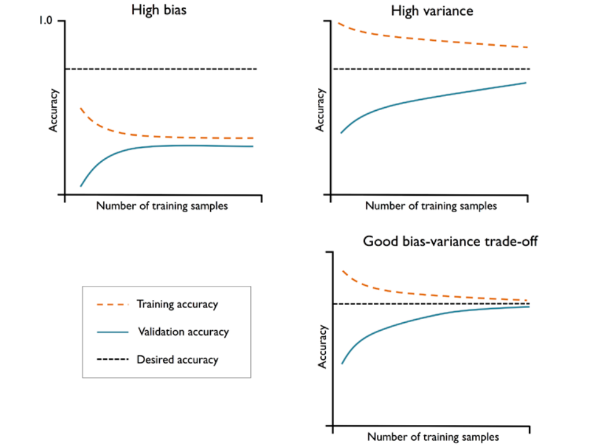

In [ ]:
# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    cls, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', shuffle=True)

Epoch 1/10
6/6 [==============================] - 1s 7ms/step - loss: 1.8006 - accuracy: 0.2247
Epoch 2/10
6/6 [==============================] - 0s 6ms/step - loss: 1.5868 - accuracy: 0.2303
Epoch 3/10
6/6 [==============================] - 0s 7ms/step - loss: 1.5958 - accuracy: 0.2191
Epoch 4/10
6/6 [==============================] - 0s 7ms/step - loss: 1.4933 - accuracy: 0.2584
Epoch 5/10
6/6 [==============================] - 0s 7ms/step - loss: 1.3696 - accuracy: 0.3876
Epoch 6/10
6/6 [==============================] - 0s 7ms/step - loss: 1.4045 - accuracy: 0.3483
Epoch 7/10
6/6 [==============================] - 0s 7ms/step - loss: 1.3512 - accuracy: 0.3539
Epoch 8/10
6/6 [==============================] - 0s 6ms/step - loss: 1.2804 - accuracy: 0.4326
Epoch 9/10
6/6 [==============================] - 0s 7ms/step - loss: 1.3100 - accuracy: 0.4438
Epoch 10/10
6/6 [==============================] - 0s 3ms/step
Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 2

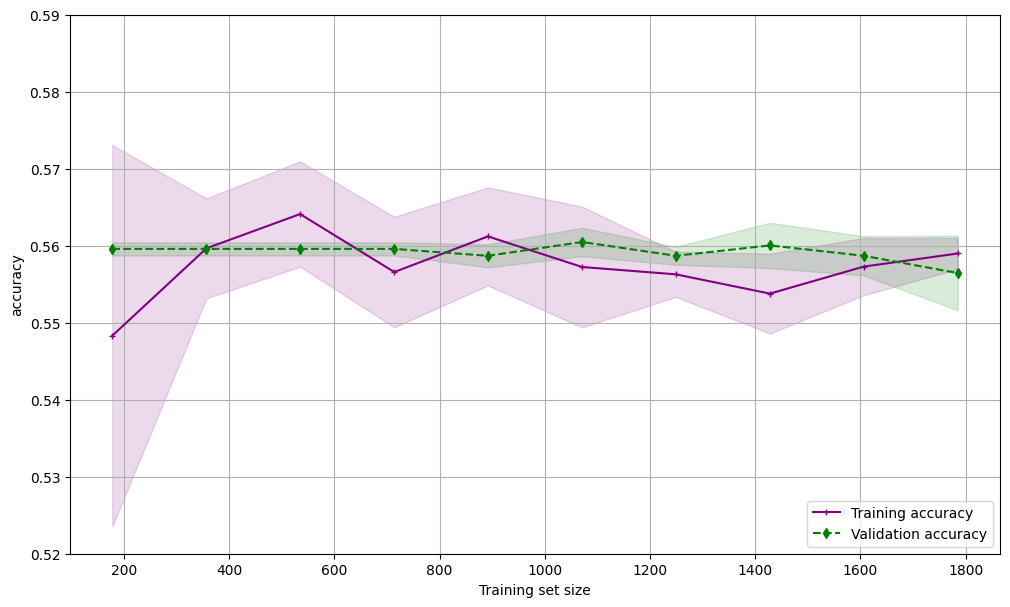

In [ ]:
# Calculate mean and standard deviation of training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation of validation scores
test_mean = np.mean(val_scores, axis=1)
test_std = np.std(val_scores, axis=1)

# Create a figure and subplot
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

# Plot training accuracy with error bands
ax.plot(train_sizes, train_mean, color='purple', marker='+', markersize=5, label='Training accuracy')
ax.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='purple')

# Plot validation accuracy with error bands
ax.plot(train_sizes, test_mean, color='green', linestyle='--', marker='d', markersize=5, label='Validation accuracy')
ax.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

# Set plot properties
ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.52, 0.59])

# Show the plot
plt.show()

Upon analyzing the learning curve in my case, it becomes apparent that there is not a significant disparity between the validation curve and the training curve. However, it is noteworthy that the accuracy values for both curves do not surpass 0.6.

Based on these observations, it can be deduced that the model does not demonstrate overfitting, as evidenced by the similarity between the curves. Instead, the primary issue lies in a high bias, resulting in underfitting. This is supported by the fact that both the training and validation curves display relatively low accuracy values.

Underfitting occurs when a model fails to capture the complexities and patterns present in the data, leading to suboptimal predictive performance. In this case, the model's simplicity and limited capacity of the embedding to treat the text message prevent it from adequately learning from the training data, resulting in inadequate performance on both the training and validation sets.




**3) Conlusion**

In conclusion, the analysis of the confusion matrix and learning curve indicates that there are limitations in the performance of the multiclass classification model. The null values in the confusion matrix suggest that the model predominantly predicts class 5 while ignoring the others in most cases, this probably due to the imbalance in the data and the decision not to address this fact in the data preprocessing stage.

However, the main problem lies in the fact that the model is underfitted, this is probably due to a simplified technique of embedding the text contained in the reviews which is definitely the most significant data and if processed poorly can contribute to the fact that the performance is not optimal.

To improve model performance, it is critical to address the problem of underfitting. To this end, more complex text embedding techniques, such as recurrent neural networks (RNNs), which can capture the intricate patterns and nuances of textual data, can be employed. In addition, addressing dataset imbalance using techniques such as oversampling or undersampling could help improve the model's ability to learn effectively from all classes.

Overall, while the confusion matrix and learning curve reveal the limitations of the current model, they provide valuable insights for future improvements. By implementing more sophisticated techniques and addressing underfitting and data imbalance problems, the model's predictive performance can be improved and better results can be obtained in multiclass classification tasks.